# Info
Purpose:

    Explore some MODIS cloud fraction and subsequent fire counts
    Adding of SMAP moisture content
      
    This program is to be run on folders of data downloaded (hdf) of MODIS cloud fraction, fire counts, and SMAP moisture
    It compiles the regional trends, and saves as .npy file format for further processing (for example      
    FOG2FIRE_cloud_fire_relationship).

Input:

    see argument list for running in command line directly

Output:

    Figure and save files

Keywords:

    none

Dependencies:

    - load_utils.py
    - matplotlib
    - numpy
    - Sp_parameters
    - write_utils
    - path_utils
    - scipy

Needed Files:
  - MYD06 and MYD14 hdf files
  - MOD06 files (for updated version)
  - SMAP_L2_SM_SP h5 files
  
Modification History:

    Written: Samuel LeBlanc, Santa Cruz, CA, 2021-05-11
    Modified: Samuel LeBlanc, Santa Cruz, CA, 2022-02-08
            - adding SMAP moisture content compilation


# Prepare python environment

In [37]:
nomap = True
import numpy as np
import Sp_parameters as Sp
import load_utils as lu
import write_utils as wu
from path_utils import getpath
import scipy.io as sio
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

import os
if not nomap:
    from mpl_toolkits.basemap import Basemap
    %matplotlib notebook

In [38]:
name = 'FOG2FIRE'
vv = 'v3'
fp = getpath(name)
yy = '2020'

('Return path named: ', 'FOG2FIRE', u'/data/sam/FOG2FIRE/')


In [116]:
import argparse
long_description = """    Quantify the cloud fraction and or the number of fire counts in the files MYD06 and MYD14. 
     Subsets and saves to a npy file for clouds or fires"""
parser = argparse.ArgumentParser(description=long_description)
parser.add_argument('-c','--cloud',help='if set, calc the cloud',action='store_true')
parser.add_argument('-f','--fires',help='if set, run the fires calcs',action='store_true')
parser.add_argument('-s','--smap',help='if set, run the smap soil moisture calcs',action='store_true')
parser.add_argument('-y','--year',nargs='?',help='year',default='2020')
parser.add_argument('-m','--modis',nargs='?',help='MYD or MOD for Terra or Aqua',default='MOD')

_StoreAction(option_strings=['-m', '--modis'], dest='modis', nargs='?', const=None, default='MOD', type=None, choices=None, help='MYD or MOD for Terra or Aqua', metavar=None)

In [123]:
in_ = vars(parser.parse_known_args()[0])
run_cloud = in_.get('cloud',False)
run_fire = in_.get('fires',False)
run_smap = in_.get('smap',False)
yy = in_.get('year').strip()
modis = in_.get('modis').strip()

In [124]:
print(in_)

{'modis': 'MOD', 'fires': False, 'smap': True, 'cloud': False, 'year': '2016'}


Web link to download the MODIS cloud files  
https://ladsweb.modaps.eosdis.nasa.gov/search/order/3/MOD06_L2--61/2004-01-01..2004-12-31/D/-125,47,-115,32.5

In [119]:
from osgeo import gdal
if gdal.__version__ > '3.2':
    load_special = True
else:
    load_special = False

# Plan out the regions

<IPython.core.display.Javascript object>


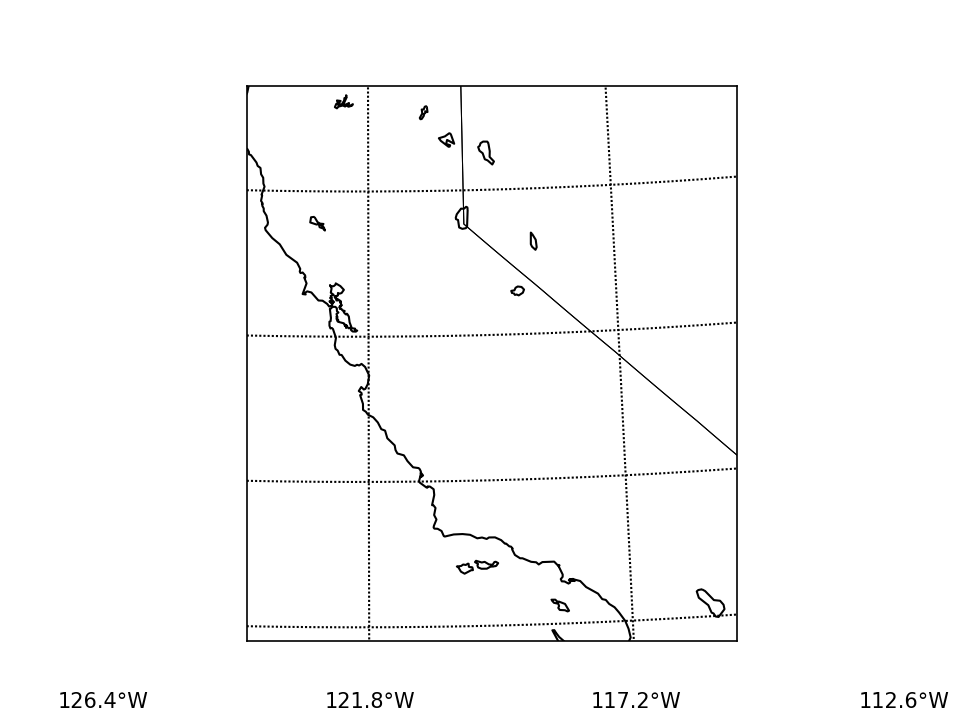

In [7]:
if not nomap:
    def make_map(ax=plt.gca()):
        m = Basemap(projection='stere',lon_0=-122.0,lat_0=38.0,
                llcrnrlon=-131.0, llcrnrlat=32.0,
                urcrnrlon=-108.0, urcrnrlat=48,resolution='i',ax=ax)
        m.drawcoastlines()
        #m.fillcontinents(color='#AAAAAA')
        m.drawstates()
        m.drawcountries()
        m.drawmeridians(np.linspace(-131,-108,6),labels=[0,0,0,1])
        m.drawparallels(np.linspace(31,48,9),labels=[1,0,0,0])
        def format_coord(x, y):
            return 'x=%.4f, y=%.4f'%(m(x, y, inverse = True))
        ax.format_coord = format_coord
        return m
    make_map()

In [120]:
rgs = [[[32.5,-121.5],[35.5,-117.0]],
       [[32.5,-117.0],[35.5,-114.0]],
       [[35.5,-123.5],[38.5,-120.8]],
       [[35.5,-120.8],[38.5,-115.0]],
       [[38.5,-125.0],[42.0,-122.0]],
       [[38.5,-122.0],[42.0,-118.0]],
       [[42.0,-125.0],[47.0,-122.0]],
       [[42.0,-122.0],[47.0,-115.0]]]
       #lower left [lat lon], upper right [lat lon]
lbls = ['Socal Coast','Socal land','Central coast','Central Sierras',
        'Norcal coast','Northern Sierras','Oregon Coast','Oregon mountains']

In [121]:
regions = {'ocean':[[[32.5,-131],[35.5,-121.5]],[[35.5,-131.0],[38.5,-123.5]], [[38.5,-131.0],[42.0,-125.0]],[[42.0,-131.0],[47.0,-125.0]]],
           'coast':[[[32.5,-121.5],[35.5,-117.0]],[[35.5,-123.5],[38.5,-120.8]], [[38.5,-125.0],[42.0,-122.0]],[[42.0,-125.0],[47.0,-122.0]]],
           'land':[[[32.5,-117.0],[35.5,-114.0]],[[35.5,-120.8],[38.5,-115.0]],[[38.5,-122.0],[42.0,-118.0]],[[42.0,-122.0],[47.0,-115.0]]],
           'points':[[[32.5,-117.22],[33.6,-116.7]],[[34.02,-118.18],[34.5,-116.63]],[[34.35,-120.7],[35.08,-118.7]],
                     [[35.37,-121.97],[36.6,-120.69]],[[35.6,-120.01],[38.43,-118.23]],[[36.9,-122.56],[37.68,-121.56]],
                     [[38.24,-121.25],[40.09,-119.92]],[[38.45,-123.98],[40.39,-122.23]],[[40.0,-122.57],[41.73,-120.37]],
                     [[40.77,-124.0],[42.0,-122.54]],[[42.05,-124.51],[43.68,-123.10]],[[43.95,-122.92],[42.82,-120.82]],
                     [[44.04,-124.15],[46.10,-122.92]],[[46.97,-124.87],[48.40,-122.58]],[[46.52,-122.69],[48.59,-120.65]]]
          }

lbls_rg = {'ocean':['SoCal','Central','NorCal','Oregon'],
           'coast':['SoCal','Central','NorCal','Oregon'],
           'land':['SoCal','Central Sierras','Northern Sierras','Oregon mountains'],
           'points':['San Diego','San Bernardino','Los Padres',
                     'Big Sur','Sierra','Santa Cruz',
                     'Eldorado','Mendocino','Lassen-Shasta',
                     'Klamath','Rogue','Mt Hood',
                     'Portland','Olympic','Mt. Baker-Rainier']
          }
ls = {'ocean':':','coast':'-','land':'--','points':'-.'}


<IPython.core.display.Javascript object>


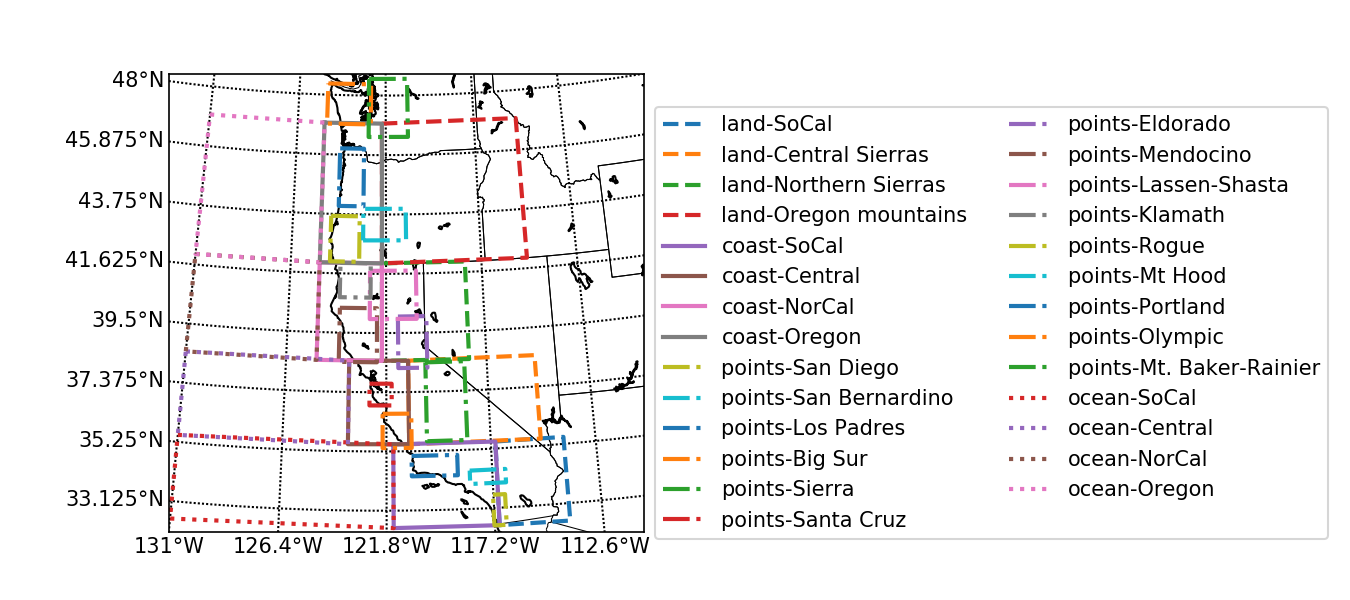

In [32]:
if not nomap:
    fig, ax = plt.subplots(1,2,figsize=(9,4))
    m = make_map(ax[0])
    ax[0].set_prop_cycle(color=[plt.cm.gist_ncar(k) for k in np.linspace(0, 1, len(i_rg[0]))])
    for re in regions:
        for i,r in enumerate(regions[re]):
            m.plot([r[0][1],r[1][1],r[1][1],r[0][1],r[0][1]],[r[1][0],r[1][0],r[0][0],r[0][0],r[1][0]],
                   latlon=True,label=re+'-'+lbls_rg[re][i],lw=2,ls=ls[re])
    ax[0].legend(bbox_to_anchor=[1.0,0.95],ncol=2,loc=2)
    #plt.tight_layout(rect=[0.1,-0.4,0.95,1.5])
    ax[1].set_visible(False)

    plt.savefig(fp+'plots/Map_regions_{}.png'.format(vv),dpi=400,transparent=True)

# Load files

## Load the Cloud files

In [107]:
if run_cloud:
    print('listdir')
    lc_all = os.listdir(fp+'{}06/{}/'.format(modis,yy))
    lc = [o for o in lc_all if 'A'+yy in o]
    lc.sort()
    nfiles = len(lc)
    ifile = 0
    
    if load_special:
        vals = (('CF','HDF4_SDS:UNKNOWN:"{}":36'),
             ('CF_night','HDF4_SDS:UNKNOWN:"{}":38'),
             ('CF_day','HDF4_SDS:UNKNOWN:"{}":40'),
             ('cld_top','HDF4_SDS:UNKNOWN:"{}":19'),
             ('scan_time','HDF4_SDS:UNKNOWN:"{}":2'),
             ('sza','HDF4_SDS:UNKNOWN:"{}":3'),
             ('surf_temp','HDF4_SDS:UNKNOWN:"{}":16'),
             ('lat','HDF4_SDS:UNKNOWN:"{}":0'),
             ('lon','HDF4_SDS:UNKNOWN:"{}":1'),
             ('QA','HDF4_SDS:UNKNOWN:"{}":111'),
             ('cld_mask','HDF4_SDS:UNKNOWN:"{}":110'))
    else:
        vals = (('CF',160),('CF_night',162),('CF_day',164),('cld_top',143),('scan_time',126),
                ('sza',127),('surf_temp',140),('lat',124),('lon',125),('QA',235),('cld_mask',234))


listdir


In [96]:
if run_cloud:
    print('loading of cloud files : {}'.format(nfiles))
    clds = []
    for i,l in enumerate(lc):
        if not l.endswith('hdf'): continue
        print('loading file: {}/{}, {}'.format(i,nfiles,l))
        try:
            if load_special:
                cld,cld_dict = lu.load_hdf_withsub(fp+'{}06/{}/'.format(modis,yy)+l,values=vals,verbose=False)
            else:
                cld,cld_dict = lu.load_hdf(fp+'{}06/{}/'.format(modis,yy)+l,values=vals,verbose=False)
            cld['surf_temp'] = (cld['surf_temp']+15000)*0.00999999977648258
            clds.append(cld)
        except:
            pass

loading of cloud files : 1
loading file: 0/1, MOD06_L2.A2003001.1755.061.2017281183635.hdf


<IPython.core.display.Javascript object>


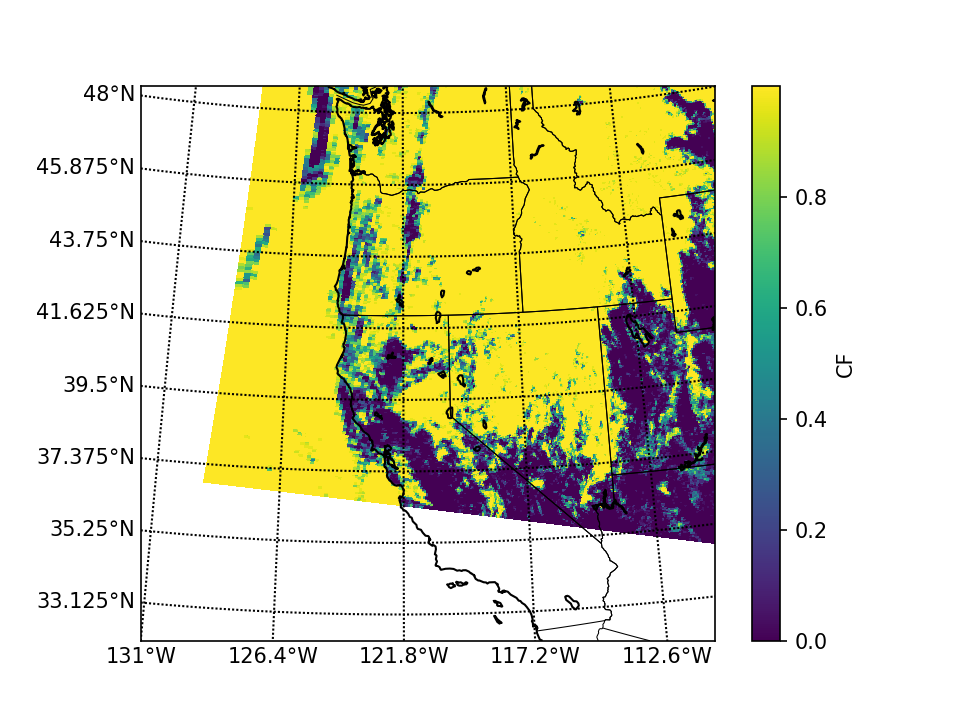

In [80]:
if not nomap:
    fig, ax = plt.subplots(1,1)
    m = make_map(ax)
    mcf = m.pcolor(cld['lon'],cld['lat'],cld['CF'],latlon=True)
    plt.colorbar(mcf,label='CF')

## Load the fire files

In [346]:
if run_fire:
    print('listdir')
    lc_all = os.listdir(fp+'MYD14/')
    lc = [o for o in lc_all if 'A'+yy in o]
    lc.sort()
    nfiles = len(lc)
    ifile = 0

listdir


In [347]:
if run_fire:
    fires,time_fires = [],[]
    print('loading of fire files : {}'.format(nfiles))
    for i,l in enumerate(lc):
        if not l.endswith('hdf'): continue
        print('loading file: {}/{}, {}'.format(i,nfiles,l))
        try: 
            fir,fir_dict = lu.load_hdf_sd(fp+'MYD14/'+l,vals=['FP_longitude','FP_latitude','FP_power'],verbose=False)
        except ValueError: 
            fir = {'FP_latitude':[],'FP_longitude':[],'FP_power':[]}
        tm = datetime.strptime(l[7:19],'%Y%j.%H%M')
        fires.append(fir)
        time_fires.append(tm)

Reading file: /data/sam/FOG2FIRE/MYD14/MYD14.A2020200.0920.006.2020200151432.hdf
Reading file: /data/sam/FOG2FIRE/MYD14/MYD14.A2020200.0925.006.2020200151439.hdf
Reading file: /data/sam/FOG2FIRE/MYD14/MYD14.A2020200.2025.006.2020201120359.hdf
Reading file: /data/sam/FOG2FIRE/MYD14/MYD14.A2020200.2030.006.2020201120339.hdf
Reading file: /data/sam/FOG2FIRE/MYD14/MYD14.A2020201.1005.006.2020202112723.hdf
Reading file: /data/sam/FOG2FIRE/MYD14/MYD14.A2020201.1010.006.2020202112641.hdf
Reading file: /data/sam/FOG2FIRE/MYD14/MYD14.A2020201.2110.006.2020202114621.hdf
Reading file: /data/sam/FOG2FIRE/MYD14/MYD14.A2020202.0910.006.2020202153511.hdf
Reading file: /data/sam/FOG2FIRE/MYD14/MYD14.A2020202.0915.006.2020202153912.hdf
Reading file: /data/sam/FOG2FIRE/MYD14/MYD14.A2020202.1045.006.2020203110308.hdf
Reading file: /data/sam/FOG2FIRE/MYD14/MYD14.A2020202.1050.006.2020203110340.hdf
Reading file: /data/sam/FOG2FIRE/MYD14/MYD14.A2020202.2015.006.2020203113354.hdf
Reading file: /data/sam/FOG2

In [348]:
if run_fire:
    fires

## Load the SMAP soil moisture files

Loading files from SMAP:  
https://nsidc.org/data/SPL2SMP/versions/8

Chan, S., R. Bindlish, P. E. O'Neill, E. G. Njoku, T. Jackson, A. Colliander, F. Chen, M. Burgin, S. Dunbar, J. R. Piepmeier, S. Yueh, D. Entekhabi, M. Cosh, T. Caldwell, J. Walker, A. Berg, T. Rowlandson, A. Pacheco, H. McNairn, M. Thibeault, J. Martinez-Fernandez, A. González-Zamora, D. Bosch, P. Starks, D. Goodrich, J. Prueger, M. Palecki, E. E. Small, M. Zreda, J. Calvet, W. T. Crow, and Y. Kerr. 2016. Assessment of the SMAP passive soil moisture product, IEEE Transactions on Geoscience and Remote Sensing. 54. 4994–5007. https://doi.org/10.1109/TGRS.2016.2561938
  
and   
  
O'Neill, P. E., S. Chan, E. G. Njoku, T. Jackson, R. Bindlish, and J. Chaubell. 2021. SMAP L2 Radiometer Half-Orbit 36 km EASE-Grid Soil Moisture, Version 8. [Indicate subset used]. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. doi: https://doi.org/10.5067/LPJ8F0TAK6E0. [Accessed 2022-02-08]. (SMAP_L2_SM_P_36065_D)

In [161]:
print('listdir')
lc_all = os.listdir(fp+'SMAP/{}/'.format(yy))
lc = [o for o in lc_all if (yy in o) and (o.endswith('h5'))]
lc.sort()
nfiles = len(lc)
ifile = 0

listdir


In [162]:
if run_smap:
    vals = (('lat',20),('lon',22),('QA',24),('soil_moist',32),('veg_wat',48),('time',36))
    smaps = []
    smaps_time = []
    print('loading of smap files : {}'.format(nfiles))
    for i,l in enumerate(lc):
        print('loading file: {}/{}, {}'.format(i,nfiles,l))
        sma,sma_dict = lu.load_hdf(fp+'SMAP/{}/'.format(yy)+l,verbose=False,values=vals,i_subdata=0)
        sma['soil_moist'][sma['soil_moist']<-9990.0] = np.nan
        smaps_time.append(datetime(2000,1,1)+timedelta(seconds=sma['time'][0,0]))
        smaps.append(sma)
    smaps_time = np.array(smaps_time)

loading of smap files : 2
loading file: 0/2, SMAP_L2_SM_SP_1BIWDV_20161226T150432_20161226T020926_124W47N_R17000_001.h5
loading file: 1/2, SMAP_L2_SM_SP_1BIWDV_20161228T143959_20161228T015259_120W47N_R17000_002.h5


## Define stats and get from regions

In [154]:
if run_cloud:
    time = []
    for i,c in enumerate(clds):
        time.append(datetime(1993,1,1,0,0,0)+timedelta(seconds=c['scan_time'][0,0]))
    time = np.array(time)

In [163]:
def stats(lon,lat,data,rg):
    'returns array of mean, median, std, and num for define area'
    if len(lon)>0:
        i = (lon >= rg[0][1]) & (lon <= rg[1][1]) & (lat >= rg[0][0]) & (lon <= rg[1][0])
        me = np.nanmean(data[i])
        md = np.nanmedian(data[i])
        st = np.nanstd(data[i])
        nu = len(np.isfinite(data[i]))
    else:
        me,md,st,nu = 0.0,0.0,0.0,0
    return [me,md,st,nu]

In [196]:
if run_cloud:
    print('doing CF')
    cf = {}
    for re in regions:
        nre = len(regions[re])
        cf[re] = {u'mean':np.zeros((nfiles,nre))+np.nan,
                  u'median':np.zeros((nfiles,nre))+np.nan,
                  u'std':np.zeros((nfiles,nre))+np.nan,
                  u'num':np.zeros((nfiles,nre))+np.nan}
        for i,r in enumerate(regions[re]):
            for ifile in range(nfiles):
                cf[re]['mean'][ifile,i],cf[re]['median'][ifile,i],cf[re]['std'][ifile,i],cf[re]['num'][ifile,i] =\
                   stats(clds[ifile]['lon'],clds[ifile]['lat'],clds[ifile]['CF'],r)

/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [197]:
if run_cloud:
    print('doing cloud top')
    cld_top = {}
    for re in regions:
        nre = len(regions[re])
        cld_top[re] = {u'mean':np.zeros((nfiles,nre))+np.nan,
                  u'median':np.zeros((nfiles,nre))+np.nan,
                  u'std':np.zeros((nfiles,nre))+np.nan,
                  u'num':np.zeros((nfiles,nre))+np.nan}
        for i,r in enumerate(regions[re]):
            for ifile in range(nfiles):
                igood = (clds[ifile]['cld_top']>0.0)
                cld_top[re]['mean'][ifile,i],cld_top[re]['median'][ifile,i],\
                cld_top[re]['std'][ifile,i],cld_top[re]['num'][ifile,i] =\
                   stats(clds[ifile]['lon'][igood],clds[ifile]['lat'][igood],clds[ifile]['cld_top'][igood],r)

In [198]:
if run_cloud:
    print('doing surface temp')
    surf_temp = {}
    for re in regions:
        nre = len(regions[re])
        surf_temp[re] = {u'mean':np.zeros((nfiles,nre))+np.nan,
                  u'median':np.zeros((nfiles,nre))+np.nan,
                  u'std':np.zeros((nfiles,nre))+np.nan,
                  u'num':np.zeros((nfiles,nre))+np.nan}
        for i,r in enumerate(regions[re]):
            for ifile in range(nfiles):
                surf_temp[re]['mean'][ifile,i],surf_temp[re]['median'][ifile,i],\
                surf_temp[re]['std'][ifile,i],surf_temp[re]['num'][ifile,i] =\
                   stats(clds[ifile]['lon'],clds[ifile]['lat'],clds[ifile]['surf_temp'],r)

/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [161]:
if run_cloud:
    print('doing sza')
    sza = {}
    for re in regions:
        nre = len(regions[re])
        sza[re] = np.zeros((nfiles,nre))+np.nan
        for i,r in enumerate(regions[re]):
            for ifile in range(nfiles):
                sza[re][ifile,i],md,st,nu =\
                   stats(clds[ifile]['lon'],clds[ifile]['lat'],clds[ifile]['sza'],r)

/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [183]:
if run_cloud:
    surf_temp

{'coast': {'mean': array([[277.8759344 , 279.50346733, 280.58619864, 280.27270207],
         [279.48401278, 280.1140719 , 281.70447692, 281.52219938],
         [291.95221794, 287.68401377, 285.53840172, 283.99939802],
         [276.48966293, 277.62776048, 279.25058339, 278.92666484],
         [290.62355533, 288.62172194, 286.94863843, 285.32453107],
         [285.82618694, 286.23644003,          nan,          nan],
         [266.11737181, 267.53604952, 268.99536015, 267.68217997],
         [294.51660791, 289.75574369, 287.35538967, 284.63140153],
         [285.99244433, 286.46080541,          nan,          nan],
         [         nan, 281.32629001, 284.02275602, 283.9944857 ],
         [281.56368021, 279.4823045 , 279.86552983, 279.18490969],
         [         nan,          nan,          nan,          nan]]),
  'median': array([[277.82999379, 279.06999376, 280.65999373, 280.34999373],
         [278.64999377, 279.18999376, 281.41999371, 281.23999371],
         [289.43999353, 286.51999

## Define stats for fire

In [350]:
if run_fire:
    print('doing fire counts')
    fire_counts = {}
    for re in regions:
        nre = len(regions[re])
        fire_counts[re] = {u'mean':np.zeros((nfiles,nre))+np.nan,
                  u'median':np.zeros((nfiles,nre))+np.nan,
                  u'std':np.zeros((nfiles,nre))+np.nan,
                  u'num':np.zeros((nfiles,nre))+np.nan}
        for i,r in enumerate(regions[re]):
            for ifile in range(nfiles):
                fire_counts[re]['mean'][ifile,i],fire_counts[re]['median'][ifile,i],\
                fire_counts[re]['std'][ifile,i],fire_counts[re]['num'][ifile,i] =\
                   stats(fires[ifile]['FP_longitude'],fires[ifile]['FP_latitude'],fires[ifile]['FP_power'],r)

doing fire counts


/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


## Define stats for SMAP

In [165]:
if run_smap:
    print('doing SMAP soil moisture')
    soil_moist = {}
    for re in regions:
        nre = len(regions[re])
        soil_moist[re] = {u'mean':np.zeros((nfiles,nre))+np.nan,
                  u'median':np.zeros((nfiles,nre))+np.nan,
                  u'std':np.zeros((nfiles,nre))+np.nan,
                  u'num':np.zeros((nfiles,nre))+np.nan}
        for i,r in enumerate(regions[re]):
            for ifile in range(nfiles):
                soil_moist[re]['mean'][ifile,i],soil_moist[re]['median'][ifile,i],\
                soil_moist[re]['std'][ifile,i],soil_moist[re]['num'][ifile,i] =\
                   stats(smaps[ifile]['lon'],smaps[ifile]['lat'],smaps[ifile]['soil_moist'],r)

doing SMAP soil moisture


/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/sam/.local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/sam/.local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/sam/.local/lib/python2.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


# Prep for saving

In [166]:
if run_cloud:
    data = {'CF':cf,'surf_temp':surf_temp,'sza':sza,'cld_top':cld_top,'time':time,'regions':regions,'lbls_rg':lbls_rg}
if run_fire:
    data = {'FP':fire_counts,'time':time_fires,'regions':regions,'lbls_rg':lbls_rg}
if run_smap:
    data = {'SM':soil_moist,'time':smaps_time,'regions':regions,'lbls_rg':lbls_rg}

In [167]:
import write_utils as wu
data = wu.iterate_dict_unicode(data)

('no', 'regions')
('no', 'lbls_rg')
('no', 'SM')
('no', 'time')


In [354]:
if run_cloud: fsuff = '{}06'.format(modis)
if run_fire: fsuff = 'MYD14' 
if run_smap: fsuff = 'SMAP'
print('Saving file to '+fp+'{}_{}_{}.npy'.format(fsuff,yy,vv))
np.save(fp+'{}_{}_{}.npy'.format(fsuff,yy,vv),data,allow_pickle=True)

Saving file to /data/sam/FOG2FIRE/MYD14_2020_v1.npy


# For determining arbitrary if point is in arbitrary polygon

In [ ]:
if False:
    import fiona
    from shapely.geometry import MultiPoint, Point, Polygon,shape
    from shapely.geometry.polygon import Polygon

    multipol = fiona.open(r"C:\Users\Jordi\Downloads\ESP_adm_shp\ESP_adm0.shp")
    multi = next(iter(multipol))

    point = Point(0,42)
    point.within(shape(multi['geometry']))